# NEURON Tutorial 2
## Objectives
- Build a ball-and-stick neuron.
- Investigate the simulation results with changing simulation settings.


In [1]:
from neuron import h
from neuron.units import ms, mV 
import matplotlib.pyplot as plt
h.load_file('stdrun.hoc')

1.0

# Ball and stick cell

In [2]:
class BallAndStick:
  def __init__(self, gid):
    self.gid = gid
    self._setup_morphology()
    self._setup_biophysics()
    
  def _setup_morphology(self):
    self.soma = h.Section(name='soma', cell=self)
    self.dend = h.Section(name='dend', cell=self)
    self.all = [self.soma, self.dend]
    self.dend.connect(self.soma)
    self.soma.L = self.soma.diam = 12.6157
    self.dend.L = 200
    self.dend.diam = 1
    
  def _setup_biophysics(self):
    for sec in self.all:
      sec.Ra = 100 # Axial resistance in Ohm * cm
      sec.cm = 1   # Membrane capacitance in micro Farads / cm^2
    # Insert active hh mechanism in the soma
    self.soma.insert('hh')
    for seg in self.soma:
      seg.hh.gnabar = 0.12
      seg.hh.gkbar = 0.036
      seg.hh.gl = 0.0003
      seg.hh.el = -54.3
    # Insert passive (leaky) channel in the dendrite
    self.dend.insert('pas')
    for seg in self.dend:
      seg.pas.g = 0.001 # Passive conductance in S/cm2
      seg.pas.e = -65
        
  def __repr__(self):
    return 'BallAndStick[{}]'.format(self.gid)
  
my_cell = BallAndStick(0)

 If we weren't sure about the units for a given mechanism's parameter, use `unit()`. Pass in a string with the parameter name, an underscore, and then the mechanism name, e.g.

In [3]:
print(h.units('gnabar_hh'))

S/cm2


In [4]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)



1.0

In [5]:
for sec in h.allsec():
  print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

BallAndStick[0].soma: hh
BallAndStick[0].dend: pas


/Users/kchen/miniconda3/envs/bmtk/lib/python3.7/site-packages/neuron/__init__.py:873: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  line, = self.plot(xs, ys, zs, '-', **kwargs)


<neuron._PlotShapePlot.__call__.<locals>._get_pyplot_axis3d.<locals>.Axis3DWithNEURON at 0x7fbfb04bb650>

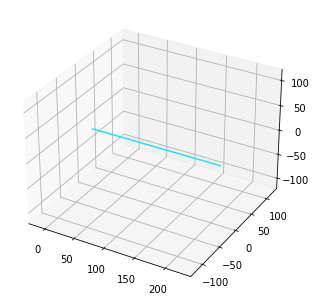

In [6]:
# To ensure the success of plot, Python3.7 is recommended. Python with version newer than 3.9 might leads dead kernel issue.
h.PlotShape(False).plot(plt)

In [7]:
from neuron import gui
ps = h.PlotShape(True)

## Simulation

In [8]:
stim = h.IClamp(my_cell.dend(1))

In [9]:
stim.get_segment()

BallAndStick[0].dend(1)

In [10]:
stim.delay = 5
stim.dur = 1
stim.amp = 0.1

In [11]:
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

## Run the simulation

In [12]:
h.finitialize(-65 * mV)

1.0

In [13]:
h.continuerun(25 * ms)

0.0

Text(0, 0.5, 'v (mV)')

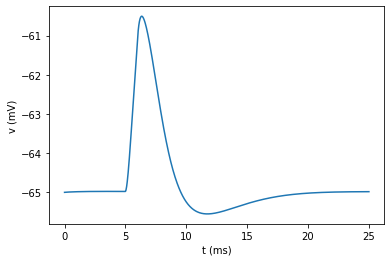

In [14]:
fig = plt.figure()
plt.plot(t, soma_v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')

## Simulation studies

#### Changing amplitude of IClamp

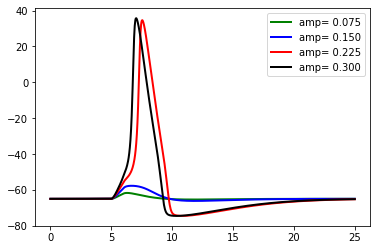

In [15]:
fig = plt.figure()
amps = [0.075 * i for i in range(1,5)]
colors = ['g','b','r','k']
for amp, color in zip(amps, colors):
  stim.amp = amp
  h.finitialize(-65*mV)
  h.continuerun(25*ms)
  plt.plot(t, soma_v, lw=2, label='amp=%6.3f'%amp, color=color)
plt.legend()

#### Recording voltage from dendrite

In [16]:
dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)

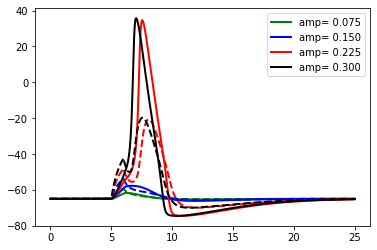

In [17]:
fig = plt.figure()
amps = [0.075 * i for i in range(1,5)]
colors = ['g','b','r','k']
for amp, color in zip(amps, colors):
  stim.amp = amp
  h.finitialize(-65*mV)
  h.continuerun(25*ms)
  plt.plot(t, soma_v, lw=2, label='amp=%6.3f'%amp, color=color)
  plt.plot(t, dend_v, lw=2, ls = '--', color=color)
plt.legend()

#### Choose different `nseg` value for dendrite 

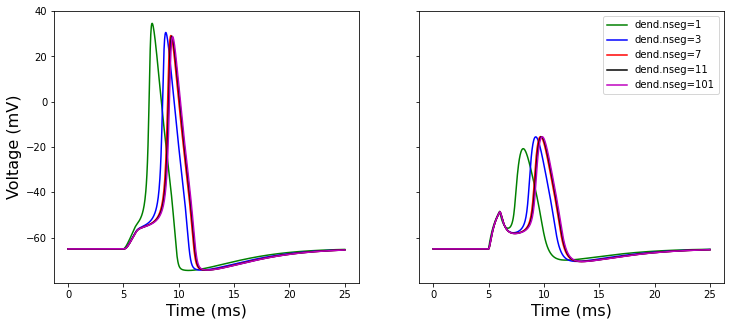

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
amp = 0.22
nsegs = [1,3,7,11,101]
colors = ['g','b','r','k','m']
for nseg, color in zip(nsegs, colors):
  stim.amp = amp
  my_cell.dend.nseg = nseg
  h.finitialize(-65*mV)
  h.continuerun(25*ms)
  ax[0].plot(t, soma_v, lw=1.5, label='dend.nseg=%d'%nseg, color=color)
  ax[1].plot(t, dend_v, lw=1.5, label='dend.nseg=%d'%nseg, color=color)
ax[0].set_ylabel('Voltage (mV)', fontsize=16)
ax[0].set_xlabel('Time (ms)', fontsize=16)
ax[1].set_xlabel('Time (ms)', fontsize=16)
plt.legend()